# Optimizacija hiperparametrov RF

In [1]:
%run __A_knjiznice.py

# Import specific elements from the script
from __A_knjiznice import *
from __B_funkcije import *
import __C_konstante as kon
%matplotlib inline

In [2]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest Classifier
from sklearn.feature_selection import SelectPercentile, chi2, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
from optuna.pruners import MedianPruner

# Load your dataset
df = pd.read_csv(f'{kon.path_files}/molekulski_prstni_odtisi/df_rdkit.csv')
y = df[['Activity']].values.ravel()  # Assuming 'Activity' is the target
X = df.iloc[:, 3:]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=kon.random_seed, stratify=y)

# Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=kon.random_seed)

# Define the Optuna optimization function
def objective(trial):
    # Random Forest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 10, 200)  # Number of trees in the forest
    max_depth = trial.suggest_int('max_depth', 1, 20)  # Maximum depth of the trees
    min_samples_split = trial.suggest_int('min_samples_split', 5, 10)  # Min samples required to split an internal node
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 10)  # Min samples required at a leaf node
    
    # Feature selection with SelectPercentile
    percentile = trial.suggest_int('percentile', 5, 50)  # Percentile between 5 and 60
    
    # Build the pipeline
    model = Pipeline([
        ('variance_threshold', VarianceThreshold()),  # Remove low-variance features
        ('select_percentile', SelectPercentile(score_func=chi2, percentile=percentile)),  # Feature selection
        ('random_forest', RandomForestClassifier(
            n_estimators=n_estimators, 
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=kon.random_seed
        ))  # Random Forest Classifier
    ])
    
    # Cross-validation: Optimize based on mean accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(cv_scores)  # Return the mean of the cross-validation scores

# Create the Optuna study and optimize it
study = optuna.create_study(direction='maximize', pruner=MedianPruner())  # Maximize accuracy
study.optimize(objective, n_trials=100)  # Adjust n_trials as needed

# Output the best trial results
print('Best trial:')
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print(f"  Params: {best_trial.params}")

[I 2025-01-26 19:44:49,493] A new study created in memory with name: no-name-26ac3469-2296-48dd-b2be-874d7fc39649
[I 2025-01-26 19:44:50,935] Trial 0 finished with value: 0.8644702966010944 and parameters: {'n_estimators': 84, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 9, 'percentile': 24}. Best is trial 0 with value: 0.8644702966010944.
[I 2025-01-26 19:44:51,583] Trial 1 finished with value: 0.8539131385763694 and parameters: {'n_estimators': 36, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 9, 'percentile': 11}. Best is trial 0 with value: 0.8644702966010944.
[I 2025-01-26 19:44:52,725] Trial 2 finished with value: 0.8551161296496288 and parameters: {'n_estimators': 97, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 10, 'percentile': 12}. Best is trial 0 with value: 0.8644702966010944.
[I 2025-01-26 19:44:53,768] Trial 3 finished with value: 0.8702045540502977 and parameters: {'n_estimators': 48, 'max_depth': 12, 'min_samples_split': 10,

Best trial:
  Value: 0.876544863820499
  Params: {'n_estimators': 183, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 5, 'percentile': 45}


Train Accuracy: 0.9191
Test Accuracy: 0.8758
Train AUC: 0.9791
Test AUC: 0.9365


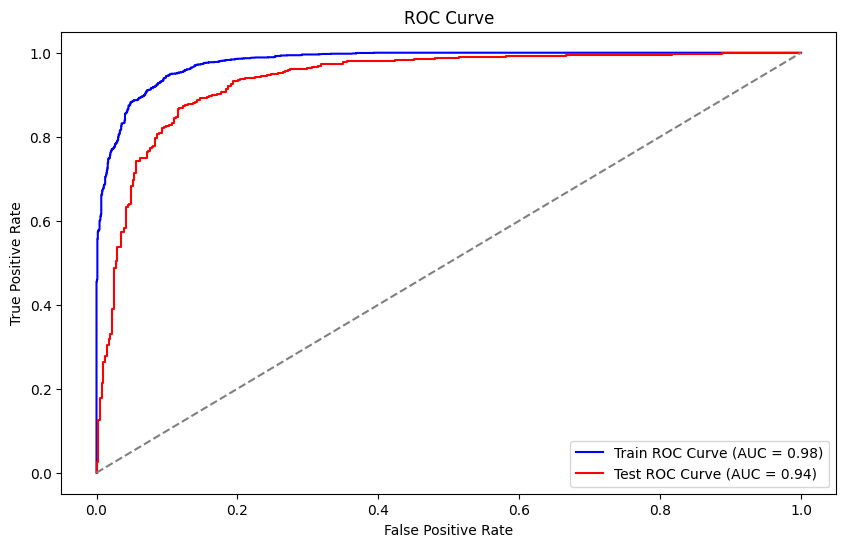

In [3]:
# Extract the best hyperparameters from Optuna
best_params = best_trial.params
n_estimators = best_params['n_estimators']
max_depth = best_params['max_depth']
min_samples_split = best_params['min_samples_split']
min_samples_leaf = best_params['min_samples_leaf']
percentile = best_params['percentile']

# Create the final pipeline with the best parameters
final_model = Pipeline([
    ('variance_threshold', VarianceThreshold()),  # Remove low variance features
    ('select_percentile', SelectPercentile(score_func=chi2, percentile=percentile)),  # Feature selection
    ('random_forest', RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=kon.random_seed
    ))  # Random Forest Classifier with best parameters
])

# Fit the model on the full training data
final_model.fit(X_train, y_train)

# Predictions for train data
y_train_pred = final_model.predict(X_train)
y_train_prob = final_model.predict_proba(X_train)[:, 1]  # Probabilities for ROC AUC

# Predictions for test data
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate accuracy and AUC for train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

# Print performance metrics
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC Curve (AUC = {train_auc:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC Curve (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

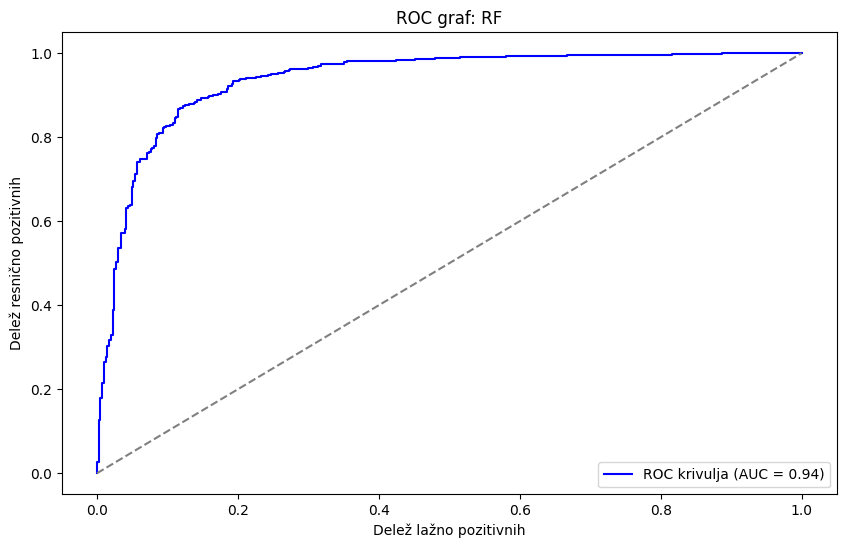

In [6]:
# plot TEST only
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, color='blue', label=f'ROC krivulja (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.title('ROC graf: RF')
plt.xlabel('Delež lažno pozitivnih')
plt.ylabel('Delež resnično pozitivnih')
plt.legend(loc='lower right')
plt.show()


Train Accuracy: 0.9191
Test Accuracy: 0.8758
Train AUC: 0.9791
Test AUC: 0.9365


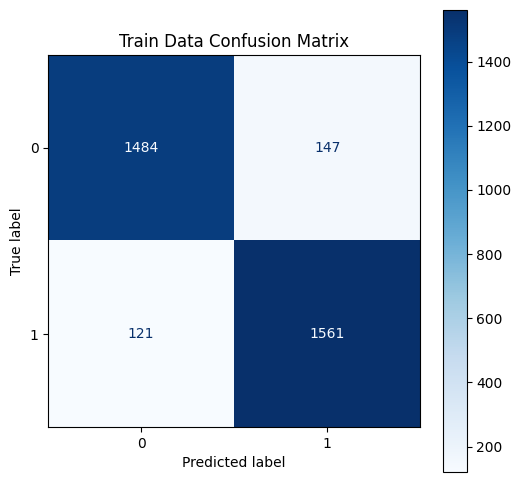

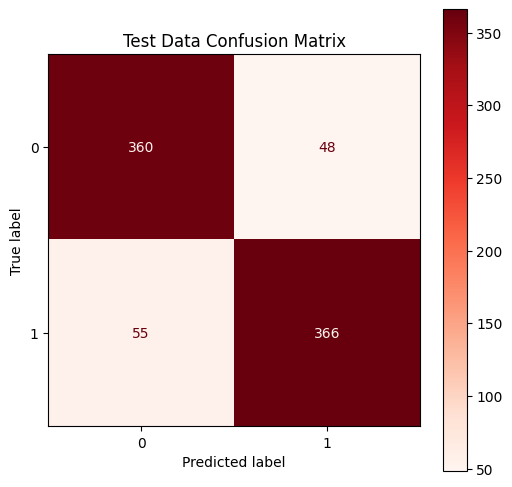

In [5]:
# Confusion Matrix for Train and Test
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

# Print accuracy and AUC scores
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


# Display Confusion Matrix for Train data
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=train_cm).plot(cmap='Blues', ax=ax)
ax.set_title('Train Data Confusion Matrix')
plt.show()

# Display Confusion Matrix for Test data
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=test_cm).plot(cmap='Reds', ax=ax)
ax.set_title('Test Data Confusion Matrix')
plt.show()